In [12]:
# HW1-Linear Regression
import sys
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [13]:
### Parameters ###
RAWDATA_PATH = './dataset/train.csv'
OBSERVE_PATH = './dataset/test.csv'
SUBMISSION_PATH = './dataset/sampleSubmission.csv'
MODE_PATH = './model'
HIS_PATH = './history'
PIC_PATH = './picture'
FEATURES = ['AMB_TEMP','CH4','CO','NMHC','NO','NO2','NOx','O3','PM10','PM2.5',
            'RAINFALL','RH','SO2','THC','WD_HR','WIND_DIREC','WIND_SPEED','WS_HR']

In [14]:
def Create_dict(raw, select='raw'):
    where_are_NaNs = np.isnan(raw)
    raw[where_are_NaNs] = 0
    month_to_data = {}
    if select == 'raw':
        raw = raw[1:,3:]
        for month in range(12):
            sample = np.empty(shape = (18 , 480))
            for day in range(20):
                for hour in range(24): 
                    sample[:,day * 24 + hour] = raw[18 * (month * 20 + day): 18 * (month * 20 + day + 1),hour]
            month_to_data[month] = sample
    elif select == 'ob':  
        raw = raw[:, 2: ]  
        for id in range(240):
            month_to_data[id] = raw[18 * id : 18 * (id+1),:]
    return month_to_data

In [4]:
def Preprocess(month_to_data, features, f_size, predict_term, select='raw'):
    n_features = len(features)
    id_features = []
    id_predict = []
    # Get id in features
    for i, name in enumerate(FEATURES):
        if name == predict_term:
            id_predict.append(i)
        for f in features:
            if f == name:
                id_features.append(i)               
    # Modify the dict, the last row is wanted to predict vaules.
    month_to_data = month_to_data.copy()
    month_to_datay = {}
    for month, data in month_to_data.items():
        month_to_data[month] = data[id_features]
        month_to_datay[month] = data[id_predict]        
    ## Select the model to preprocess the data
    if select == 'raw':
        # Sample every 10 hrs: previous 9-hr as train-feature, 10th-hr as train-predict
        # Every month's 0~9 hrs cannot be predict.
        x = np.empty(shape = (12 * (480-f_size) , n_features * f_size),dtype = float)
        y = np.empty(shape = (12 * (480-f_size) , 1),dtype = float)
        for month in range(12): 
            for day in range(20): 
                for hour in range(24):   
                    if day == 19 and hour > (23-f_size):
                        continue  
                    x[month * (480-f_size) + day * 24 + hour,:] = month_to_data[month][:,day * 24 + hour : day * 24 + hour + f_size].reshape(1,-1) 
                    y[month * (480-f_size) + day * 24 + hour,0] = month_to_datay[month][:,day * 24 + hour + f_size] # Predict term
        return x,y
    elif select == 'ob':
        if f_size == 9:
            x = np.empty(shape = (240, n_features * f_size),dtype = float)
            y = np.empty(shape = (240, 1),dtype = float)
            for idx in range(240):
                x[idx,:] = month_to_data[idx][:,:].reshape(1,-1) 
            x_p, y_p = x,y
        elif f_size < 9:
            x = np.empty(shape = (240 * (9-f_size), n_features * f_size),dtype = float)
            y = np.empty(shape = (240 * (9-f_size), 1),dtype = float)  
            x_p = np.empty(shape = (240, n_features * f_size),dtype=float)
            y_p = np.empty(shape = (240, 1),dtype=float)    
            # get the train data from ob data
            for idx in range(240):
                for hour in range(9):
                    # get the feature to predict
                    if hour == 9-f_size:
                        x_p[idx,:] = month_to_data[idx][:,hour : hour + f_size].reshape(1,-1)
                    if hour > 8-f_size:
                        continue
                    x[idx * (9-f_size) + hour,:] = month_to_data[idx][:,hour : hour + f_size].reshape(1,-1)
                    y[idx * (9-f_size) + hour,0] = month_to_datay[idx][:,hour + f_size]
        return x,y,x_p,y_p

In [16]:
def Normalization(x,mean='None',std='None',trans=False):
    ## Normalization
    if trans == False:
        mean = np.mean(x, axis = 0) 
        std = np.std(x, axis = 0)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if not std[j] == 0 :
                x[i][j] = (x[i][j]- mean[j]) / std[j]
    if trans:
        return x
    else:
        return x,mean,std

In [17]:
def Split_train_test(x,y,train_rate=0.7):
    perm = np.random.permutation(len(y))
    x, y = x[perm], y[perm]
    split_pos = np.round(len(y)*train_rate).astype('int32')
    return x[:split_pos], x[split_pos:], y[:split_pos], y[split_pos:]

In [2]:
def Fit(X,y,val=None,validation_split=0.0,bias=True,weights='zeros',
      loss='rmse',opt='vanilla',regularization=None,lamda=0.0005,learning_rate=200,
      epochs=1,batch_size=None,patience=None,save_model=True):

    def initial(X,weights,bias):    
        dim = X.shape[1]
        if bias:
            dim = dim + 1
            X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1).astype(float)
        if weights == 'zeros':
            w = np.zeros(shape=(dim, 1))
        elif weights == 'random':
            w = np.random.rand(dim, 1)
        return X, w
    # loss_value      
    def loss_value(X,y,w,loss):
        if loss == 'mse':
            pred = X.dot(w)
            square_error = (y-pred)**2
            mse = square_error.sum()/len(y)
            return mse
        elif loss == 'rmse':
            mse = loss_value(X,y,w,'mse')
            return np.power(mse,0.5)
    # Optmize function
    def update_parameters(X,y,w,sigma,m,opt,b1=0.9,b2=0.999):
        EPSILON = 1e-08
        if regularization == 'l1':
            reg = lamda * w
        elif regularization == 'l2':
            reg = 2. * lamda * w
        elif regularization == None:
            reg = lamda
        pred = X.dot(w)
        grad = -2. * np.dot(X.T,y-pred) + reg
        if opt == 'ada':
            sigma += np.sqrt(grad**2)
            w -= grad * learning_rate / sigma 
        elif opt == 'RMSProp':
            sigma = np.sqrt(b2 * sigma**2 + (1-b2) * grad**2)
            w -= grad * learning_rate / (sigma + EPSILON) 
        elif opt == 'Adam':
            m = (b1 * m + (1-b1) * grad) / (1-b1)
            sigma = np.sqrt((b2 * sigma + (1-b2) * grad**2) / (1-b2))
            w -= m * learning_rate / (sigma + EPSILON)
        else:
            m = b1 * m + (1-b1) * grad # momentum
            w -= m * learning_rate
        return w, sigma
    
    def get_mini_batch(X,y,batch_size):
        mini_batches = []
        data = np.hstack((X,y))
        np.random.shuffle(data) 
        n_minibatches = data.shape[0] 
        for i in range(n_minibatches + 1): 
            mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
            X_mini = mini_batch[:, :-1] 
            Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
            mini_batches.append((X_mini, Y_mini)) 
        if data.shape[0] % batch_size != 0: 
            mini_batch = data[i * batch_size:data.shape[0]] 
            X_mini = mini_batch[:, :-1] 
            Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
            mini_batches.append((X_mini, Y_mini)) 
        return mini_batches

    # Split Training and Validation Set
    if val:
        X_t,X_v,y_t,y_v = Split_train_test(X,y,(1-validation_split))
    else:
        X_t,X_v,y_t,y_v = X,X,y,y
    
    # Fitting summary
    print('training sample:',len(X_t),' validation sample:',len(X_v))

    # Initialization
    X_t, w = initial(X_t,weights,bias)
    X_v, w_v = initial(X_v,weights,bias)  
    # Set model parameter
    sigma = None
    m = 0
    if opt == 'stg':
        batch_size = 1
    elif opt == 'ada' or 'RMSProp' or 'Adam':
        sigma = np.zeros(w.shape)   
    # Mini-Batch Training    
    cost_history = []
    see_best_cost,see = None,0
    best_w = np.copy(w) # if we use '=', it will assign the same address.
    for epoch in range(epochs):
        # Shuffle 
        perm = np.random.permutation(len(y_t))
        X_t, y_t = X_t[perm], y_t[perm]
        
        if batch_size == None:
                # Update weights
                w, sigma = update_parameters(X_t,y_t,w,sigma,m,opt)    
        # Using mini-batch, get batch data
        else:
            mini_batches = get_mini_batch(X_t, y_t, batch_size)
            for mini_batch in mini_batches: 
                X_mini, y_mini = mini_batch 
                # Update weights
                w, sigma = update_parameters(X_mini,y_mini,w,sigma,m,opt)
        # Cost
        cost = loss_value(X_t,y_t,w,loss) # on training set
        cost_v = loss_value(X_v,y_v,w,loss) # on validation ser
        cost_history.append((cost,cost_v))       
        print('Epoch:'+str(epoch) + '/' + str(epochs),'-loss: %.3f' % cost," val loss: %.3f" % cost_v)
        # Early Stopping - Avoid Overfitting
        if patience != None:
            see += 1
            if see_best_cost == None:
                see_best_cost = np.round(cost,decimals=3)    
            elif see_best_cost > cost:   
                see_best_cost = np.round(cost,decimals=3)
                see = 0
                best_w = np.copy(w)
                continue
            elif see_best_cost < cost:      
                print('The current loss %.3f'%cost,'is not best than',see_best_cost) 
                if see < patience:
                    continue
                else:
                    print('early stopping',see,'/',patience)
                    break
    # Save the best model
    if save_model != False:
        if patience != None:
            np.save(MODE_PATH+'/'+save_model+'_weight.npy',best_w) # save best weight
        else:
            np.save(MODE_PATH+'/'+save_model+'_weight.npy',w)
        np.save(HIS_PATH+'/'+save_model+'_history.npy',np.asarray(cost_history)) # save history
    return w, np.asarray(cost_history)

In [2]:
def Plot_loss_history(history,save_model):
    plt.clf()
    loss_t, loss_v = history[:,0], history[:,1]
    plt.plot(loss_t,'b')
    plt.plot(loss_v,'r')
    plt.legend(['loss', 'val_loss'], loc="upper left")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training Process")
    if save_model == False:     
        plt.savefig(PIC_PATH+'/_history.png')
    else:
        plt.savefig(PIC_PATH+'/'+save_model+'_history.png')
    plt.show()
    plt.close()

training sample: 5595  validation sample: 57
Epoch:0/128 -loss: 15766.000  val loss: 17082.850
Epoch:1/128 -loss: 2023.998  val loss: 2015.683
Epoch:2/128 -loss: 768.555  val loss: 669.895
Epoch:3/128 -loss: 509.007  val loss: 477.183
Epoch:4/128 -loss: 407.054  val loss: 364.452
Epoch:5/128 -loss: 347.210  val loss: 301.389
Epoch:6/128 -loss: 308.116  val loss: 259.613
Epoch:7/128 -loss: 280.824  val loss: 230.347
Epoch:8/128 -loss: 260.857  val loss: 208.852
Epoch:9/128 -loss: 245.728  val loss: 192.490
Epoch:10/128 -loss: 233.946  val loss: 179.692
Epoch:11/128 -loss: 224.559  val loss: 169.471
Epoch:12/128 -loss: 216.927  val loss: 161.174
Epoch:13/128 -loss: 210.608  val loss: 154.346
Epoch:14/128 -loss: 205.285  val loss: 148.662
Epoch:15/128 -loss: 200.727  val loss: 143.878
Epoch:16/128 -loss: 196.766  val loss: 139.813
Epoch:17/128 -loss: 193.277  val loss: 136.326
Epoch:18/128 -loss: 190.165  val loss: 133.310
Epoch:19/128 -loss: 187.358  val loss: 130.678
Epoch:20/128 -loss:

Epoch:52/128 -loss: 6.687  val loss: 7.537
Epoch:53/128 -loss: 6.678  val loss: 7.511
Epoch:54/128 -loss: 6.668  val loss: 7.487
Epoch:55/128 -loss: 6.659  val loss: 7.463
Epoch:56/128 -loss: 6.650  val loss: 7.439
Epoch:57/128 -loss: 6.642  val loss: 7.417
Epoch:58/128 -loss: 6.634  val loss: 7.395
Epoch:59/128 -loss: 6.625  val loss: 7.373
Epoch:60/128 -loss: 6.618  val loss: 7.352
Epoch:61/128 -loss: 6.610  val loss: 7.332
Epoch:62/128 -loss: 6.602  val loss: 7.312
Epoch:63/128 -loss: 6.595  val loss: 7.293
Epoch:64/128 -loss: 6.588  val loss: 7.274
Epoch:65/128 -loss: 6.581  val loss: 7.256
Epoch:66/128 -loss: 6.574  val loss: 7.238
Epoch:67/128 -loss: 6.568  val loss: 7.220
Epoch:68/128 -loss: 6.562  val loss: 7.203
Epoch:69/128 -loss: 6.555  val loss: 7.187
Epoch:70/128 -loss: 6.549  val loss: 7.171
Epoch:71/128 -loss: 6.543  val loss: 7.155
Epoch:72/128 -loss: 6.537  val loss: 7.140
Epoch:73/128 -loss: 6.532  val loss: 7.125
Epoch:74/128 -loss: 6.526  val loss: 7.110
Epoch:75/12

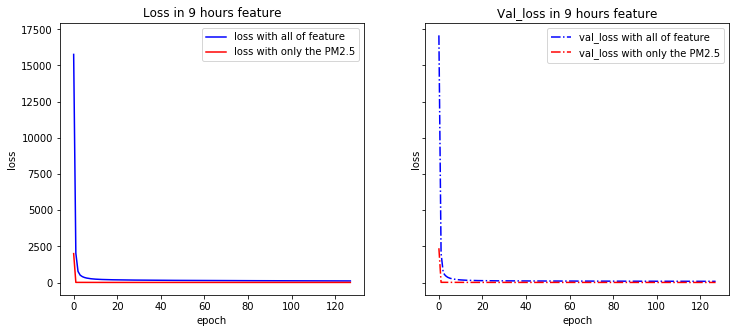

In [82]:
# 1. (2%)記錄誤差值 (RMSE)(根據kaggle public+private分數)，討論兩種feature的影響
# Model_1:抽全部9小時內的污染源feature當作一次項(加bias)
with open(RAWDATA_PATH) as f: 
    raw = np.genfromtxt(f,delimiter=',') ## Read in raw data
month_to_data = Create_dict(raw) ## Create the data dictory
features = FEATURES ## All of the feature
f_size = 9 ## in 9 hours
predict_term = 'PM2.5' 
X, y = Preprocess(month_to_data, features, f_size, predict_term)
X,mean,std = Normalization(X) ## Normalization
X_train, y_train = X, y ## Split to training and testing set

##  Training
val=True
validation_split=0.01
bias=True
weights='zeros'
loss='rmse'
opt='ada'
regularization=None
lamda= 0
learning_rate=256
epochs=128
batch_size=None
patience=16
save_model=False

model_1, history_1 = Fit(X_train,y_train,val,validation_split,bias,weights,
                      loss,opt,regularization,lamda,learning_rate,
                      epochs,batch_size,patience,save_model)

# Model_2: 抽全部9小時內pm2.5的一次項當作feature(加bias)
with open(RAWDATA_PATH) as f: 
    raw = np.genfromtxt(f,delimiter=',') ## Read in raw data
month_to_data = Create_dict(raw) ## Create the data dictory
features = ['PM2.5'] ## Only with 'PM2.5'
f_size = 9 ## in 9 hours
predict_term = 'PM2.5' 
X, y = Preprocess(month_to_data, features, f_size, predict_term)
X,mean,std = Normalization(X) ## Normalization
X_train, y_train = X, y ## Split to training and testing set

##  Training
val=True
validation_split=0.01
bias=True
weights='zeros'
loss='rmse'
opt='ada'
regularization=None
lamda= 0
learning_rate=256
epochs=128
batch_size=None
patience=16
save_model=False

model_2, history_2 = Fit(X_train,y_train,val,validation_split,bias,weights,
                      loss,opt,regularization,lamda,learning_rate,
                      epochs,batch_size,patience,save_model)

fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,5)) 
loss_t1, loss_v1 = history_1[:,0], history_1[:,1]
loss_t2, loss_v2 = history_2[:,0], history_2[:,1]
ax1.plot(loss_t1,'b',label='loss with all of feature')
ax1.plot(loss_t2,'r',label='loss with only the PM2.5')
ax1.set_title("Loss in 9 hours feature")   
ax1.legend(loc='upper right')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")  

ax2.plot(loss_v1,'b-.',label='val_loss with all of feature') 
ax2.plot(loss_v2,'r-.',label='val_loss with only the PM2.5')
ax2.set_title("Val_loss in 9 hours feature")   
ax2.legend(loc='upper right')
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")  

plt.show()
plt.close()

training sample: 5643  validation sample: 57
Epoch:0/128 -loss: 9493.323  val loss: 9005.672
Epoch:1/128 -loss: 512.257  val loss: 451.733
Epoch:2/128 -loss: 733.265  val loss: 670.138
The current loss 733.265 is not best than 512.257
Epoch:3/128 -loss: 344.634  val loss: 392.390
Epoch:4/128 -loss: 130.630  val loss: 102.850
Epoch:5/128 -loss: 86.219  val loss: 83.559
Epoch:6/128 -loss: 78.975  val loss: 67.763
Epoch:7/128 -loss: 75.778  val loss: 67.332
Epoch:8/128 -loss: 73.407  val loss: 65.283
Epoch:9/128 -loss: 71.449  val loss: 64.045
Epoch:10/128 -loss: 69.767  val loss: 62.873
Epoch:11/128 -loss: 68.286  val loss: 61.845
Epoch:12/128 -loss: 66.958  val loss: 60.903
Epoch:13/128 -loss: 65.753  val loss: 60.035
Epoch:14/128 -loss: 64.650  val loss: 59.229
Epoch:15/128 -loss: 63.633  val loss: 58.474
Epoch:16/128 -loss: 62.691  val loss: 57.764
Epoch:17/128 -loss: 61.813  val loss: 57.094
Epoch:18/128 -loss: 60.992  val loss: 56.459
Epoch:19/128 -loss: 60.222  val loss: 55.855
Epo

Epoch:59/128 -loss: 6.455  val loss: 4.665
Epoch:60/128 -loss: 6.450  val loss: 4.665
Epoch:61/128 -loss: 6.444  val loss: 4.666
Epoch:62/128 -loss: 6.439  val loss: 4.667
Epoch:63/128 -loss: 6.434  val loss: 4.668
Epoch:64/128 -loss: 6.429  val loss: 4.669
Epoch:65/128 -loss: 6.425  val loss: 4.670
Epoch:66/128 -loss: 6.420  val loss: 4.671
Epoch:67/128 -loss: 6.416  val loss: 4.672
Epoch:68/128 -loss: 6.411  val loss: 4.673
Epoch:69/128 -loss: 6.407  val loss: 4.675
Epoch:70/128 -loss: 6.403  val loss: 4.676
Epoch:71/128 -loss: 6.399  val loss: 4.677
Epoch:72/128 -loss: 6.395  val loss: 4.679
Epoch:73/128 -loss: 6.392  val loss: 4.680
Epoch:74/128 -loss: 6.388  val loss: 4.682
Epoch:75/128 -loss: 6.385  val loss: 4.683
Epoch:76/128 -loss: 6.381  val loss: 4.685
Epoch:77/128 -loss: 6.378  val loss: 4.687
Epoch:78/128 -loss: 6.374  val loss: 4.688
Epoch:79/128 -loss: 6.371  val loss: 4.690
Epoch:80/128 -loss: 6.368  val loss: 4.691
Epoch:81/128 -loss: 6.365  val loss: 4.693
Epoch:82/12

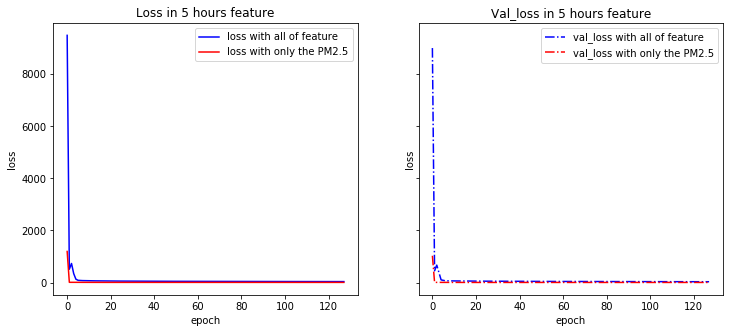

In [83]:
#2. (1%)將feature從抽前9小時改成抽前5小時，討論其變化
# Model_1: 全部污染源feature當作一次項(加bias)
with open(RAWDATA_PATH) as f: 
    raw = np.genfromtxt(f,delimiter=',') ## Read in raw data
month_to_data = Create_dict(raw) ## Create the data dictory
features = FEATURES ## All of the feature
f_size = 5 ## in 5 hours
predict_term = 'PM2.5' 
X, y = Preprocess(month_to_data, features, f_size, predict_term)
X,mean,std = Normalization(X) ## Normalization
X_train, y_train = X, y ## Split to training and testing set

##  Training
val=True
validation_split=0.01
bias=True
weights='zeros'
loss='rmse'
opt='ada'
regularization=None
lamda= 0
learning_rate=256
epochs=128
batch_size=None
patience=16
save_model=False

model_1, history_1 = Fit(X_train,y_train,val,validation_split,bias,weights,
                      loss,opt,regularization,lamda,learning_rate,
                      epochs,batch_size,patience,save_model)

# Model_2: 只有pm2.5的一次項當作feature(加bias)
with open(RAWDATA_PATH) as f: 
    raw = np.genfromtxt(f,delimiter=',') ## Read in raw data
month_to_data = Create_dict(raw) ## Create the data dictory
features = ['PM2.5'] ## Only with 'PM2.5'
f_size = 5 ## in 5 hours
predict_term = 'PM2.5' 
X, y = Preprocess(month_to_data, features, f_size, predict_term)
X,mean,std = Normalization(X) ## Normalization
X_train, y_train = X, y ## Split to training and testing set

##  Training
val=True
validation_split=0.01
bias=True
weights='zeros'
loss='rmse'
opt='ada'
regularization=None
lamda= 0
learning_rate=256
epochs=128
batch_size=None
patience=16
save_model=False

model_2, history_2 = Fit(X_train,y_train,val,validation_split,bias,weights,
                      loss,opt,regularization,lamda,learning_rate,
                      epochs,batch_size,patience,save_model)

fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,5)) 
loss_t1, loss_v1 = history_1[:,0], history_1[:,1]
loss_t2, loss_v2 = history_2[:,0], history_2[:,1]
ax1.plot(loss_t1,'b',label='loss with all of feature')
ax1.plot(loss_t2,'r',label='loss with only the PM2.5')
ax1.set_title("Loss in 5 hours feature")   
ax1.legend(loc='upper right')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")  

ax2.plot(loss_v1,'b-.',label='val_loss with all of feature') 
ax2.plot(loss_v2,'r-.',label='val_loss with only the PM2.5')
ax2.set_title("Val_loss in 5 hours feature")   
ax2.legend(loc='upper right')
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")  

plt.show()
plt.close()

training sample: 5595  validation sample: 57
Epoch:0/128 -loss: 543.698  val loss: 456.287
Epoch:1/128 -loss: 399.940  val loss: 355.449
Epoch:2/128 -loss: 330.519  val loss: 306.304
Epoch:3/128 -loss: 286.127  val loss: 267.724
Epoch:4/128 -loss: 254.595  val loss: 246.187
Epoch:5/128 -loss: 231.674  val loss: 225.515
Epoch:6/128 -loss: 213.242  val loss: 213.379
Epoch:7/128 -loss: 198.654  val loss: 203.452
Epoch:8/128 -loss: 186.224  val loss: 184.989
Epoch:9/128 -loss: 176.048  val loss: 175.612
Epoch:10/128 -loss: 167.890  val loss: 167.781
Epoch:11/128 -loss: 160.089  val loss: 160.921
Epoch:12/128 -loss: 153.084  val loss: 154.127
Epoch:13/128 -loss: 147.769  val loss: 148.590
Epoch:14/128 -loss: 142.096  val loss: 144.654
Epoch:15/128 -loss: 137.473  val loss: 141.176
Epoch:16/128 -loss: 133.268  val loss: 135.586
Epoch:17/128 -loss: 129.993  val loss: 132.189
Epoch:18/128 -loss: 126.108  val loss: 126.837
Epoch:19/128 -loss: 123.191  val loss: 122.663
Epoch:20/128 -loss: 120.2

Epoch:49/128 -loss: 9.109  val loss: 8.129
The current loss 9.109 is not best than 9.092
Epoch:50/128 -loss: 8.965  val loss: 7.959
Epoch:51/128 -loss: 8.901  val loss: 7.726
Epoch:52/128 -loss: 8.860  val loss: 8.104
Epoch:53/128 -loss: 8.778  val loss: 7.759
Epoch:54/128 -loss: 8.755  val loss: 7.587
Epoch:55/128 -loss: 8.705  val loss: 7.629
Epoch:56/128 -loss: 8.622  val loss: 7.702
Epoch:57/128 -loss: 8.581  val loss: 7.585
Epoch:58/128 -loss: 8.538  val loss: 7.702
Epoch:59/128 -loss: 8.485  val loss: 7.615
Epoch:60/128 -loss: 8.476  val loss: 7.616
Epoch:61/128 -loss: 8.412  val loss: 7.488
Epoch:62/128 -loss: 8.421  val loss: 7.542
The current loss 8.421 is not best than 8.412
Epoch:63/128 -loss: 8.427  val loss: 7.481
The current loss 8.427 is not best than 8.412
Epoch:64/128 -loss: 8.293  val loss: 7.449
Epoch:65/128 -loss: 8.238  val loss: 7.231
Epoch:66/128 -loss: 8.203  val loss: 7.357
Epoch:67/128 -loss: 8.203  val loss: 7.375
The current loss 8.203 is not best than 8.203

Epoch:87/128 -loss: 44.413  val loss: 42.212
Epoch:88/128 -loss: 44.092  val loss: 42.275
Epoch:89/128 -loss: 43.855  val loss: 42.200
Epoch:90/128 -loss: 43.600  val loss: 41.905
Epoch:91/128 -loss: 43.317  val loss: 41.342
Epoch:92/128 -loss: 43.057  val loss: 41.466
Epoch:93/128 -loss: 42.946  val loss: 41.099
Epoch:94/128 -loss: 42.574  val loss: 40.932
Epoch:95/128 -loss: 42.350  val loss: 40.635
Epoch:96/128 -loss: 42.083  val loss: 40.095
Epoch:97/128 -loss: 41.863  val loss: 40.058
Epoch:98/128 -loss: 41.608  val loss: 39.915
Epoch:99/128 -loss: 41.406  val loss: 39.911
Epoch:100/128 -loss: 41.168  val loss: 39.412
Epoch:101/128 -loss: 41.031  val loss: 38.797
Epoch:102/128 -loss: 40.862  val loss: 38.572
Epoch:103/128 -loss: 40.512  val loss: 38.841
Epoch:104/128 -loss: 40.302  val loss: 38.464
Epoch:105/128 -loss: 40.107  val loss: 38.480
Epoch:106/128 -loss: 39.865  val loss: 38.274
Epoch:107/128 -loss: 39.663  val loss: 38.060
Epoch:108/128 -loss: 39.544  val loss: 37.595
E

Epoch:126/128 -loss: 8.027  val loss: 6.028
Epoch:127/128 -loss: 8.016  val loss: 5.979
training sample: 5643  validation sample: 57
Epoch:0/128 -loss: 7.217  val loss: 6.878
Epoch:1/128 -loss: 6.639  val loss: 6.644
Epoch:2/128 -loss: 6.732  val loss: 6.543
The current loss 6.732 is not best than 6.639
Epoch:3/128 -loss: 6.434  val loss: 6.598
Epoch:4/128 -loss: 6.413  val loss: 6.405
Epoch:5/128 -loss: 6.639  val loss: 6.428
The current loss 6.639 is not best than 6.413
Epoch:6/128 -loss: 6.570  val loss: 6.420
The current loss 6.570 is not best than 6.413
Epoch:7/128 -loss: 6.811  val loss: 6.429
The current loss 6.811 is not best than 6.413
Epoch:8/128 -loss: 6.489  val loss: 6.375
The current loss 6.489 is not best than 6.413
Epoch:9/128 -loss: 6.365  val loss: 6.511
Epoch:10/128 -loss: 6.326  val loss: 6.586
Epoch:11/128 -loss: 6.393  val loss: 6.370
The current loss 6.393 is not best than 6.326
Epoch:12/128 -loss: 6.326  val loss: 6.430
Epoch:13/128 -loss: 6.574  val loss: 6.371

Epoch:9/128 -loss: 6.215  val loss: 5.927
Epoch:10/128 -loss: 6.217  val loss: 5.995
The current loss 6.217 is not best than 6.215
Epoch:11/128 -loss: 6.241  val loss: 6.131
The current loss 6.241 is not best than 6.215
Epoch:12/128 -loss: 6.216  val loss: 5.982
The current loss 6.216 is not best than 6.215
Epoch:13/128 -loss: 6.226  val loss: 6.092
The current loss 6.226 is not best than 6.215
Epoch:14/128 -loss: 6.222  val loss: 5.944
The current loss 6.222 is not best than 6.215
Epoch:15/128 -loss: 6.228  val loss: 5.958
The current loss 6.228 is not best than 6.215
Epoch:16/128 -loss: 6.226  val loss: 6.091
The current loss 6.226 is not best than 6.215
Epoch:17/128 -loss: 6.220  val loss: 5.924
The current loss 6.220 is not best than 6.215
Epoch:18/128 -loss: 6.215  val loss: 5.952
The current loss 6.215 is not best than 6.215
Epoch:19/128 -loss: 6.246  val loss: 6.037
The current loss 6.246 is not best than 6.215
Epoch:20/128 -loss: 6.213  val loss: 5.906
Epoch:21/128 -loss: 6.227

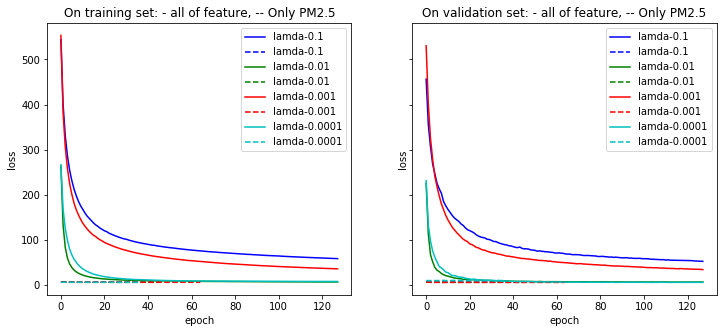

In [84]:
#3. (1%)Regularization on all the weight with λ=0.1、0.01、0.001、0.0001，並作圖
# Model_1: 全部污染源feature當作一次項(加bias)
with open(RAWDATA_PATH) as f: 
    raw = np.genfromtxt(f,delimiter=',') ## Read in raw data
month_to_data = Create_dict(raw) ## Create the data dictory
features = FEATURES ## All of the feature
f_size = 9 ## in 5 hours
predict_term = 'PM2.5' 
X, y = Preprocess(month_to_data, features, f_size, predict_term)
X,mean,std = Normalization(X) ## Normalization
X_train, y_train = X, y ## Split to training and testing set

his1_total =[]
LMBDA = [0.1,0.01,0.001,0.0001]
for i,lamda in enumerate(LMBDA):
    ##  Training
    val=True
    validation_split=0.01
    bias=True
    weights='zeros'
    loss='rmse'
    opt='ada'
    regularization=None
    learning_rate=256
    epochs=128
    batch_size=128
    patience=16
    save_model=False

    model_1, history_1 = Fit(X_train,y_train,val,validation_split,bias,weights,
                          loss,opt,regularization,lamda,learning_rate,
                          epochs,batch_size,patience,save_model)
    his1_total.append(history_1)

# Model_2: 只有pm2.5的一次項當作feature(加bias)
with open(RAWDATA_PATH) as f: 
    raw = np.genfromtxt(f,delimiter=',') ## Read in raw data
month_to_data = Create_dict(raw) ## Create the data dictory
features = ['PM2.5'] ## Only with 'PM2.5'
f_size = 5 ## in 5 hours
predict_term = 'PM2.5' 
X, y = Preprocess(month_to_data, features, f_size, predict_term)
X,mean,std = Normalization(X) ## Normalization
X_train, y_train = X, y ## Split to training and testing set

his2_total =[]
for i,lamda in enumerate(LMBDA):
    ##  Training
    val=True
    validation_split=0.01
    bias=True
    weights='zeros'
    loss='rmse'
    opt='ada'
    regularization=None
    learning_rate=256
    epochs=128
    batch_size=128
    patience=16
    save_model=False

    model_2, history_2 = Fit(X_train,y_train,val,validation_split,bias,weights,
                          loss,opt,regularization,lamda,learning_rate,
                          epochs,batch_size,patience,save_model)
    his2_total.append(history_2)
    

color =['b','g','r','c']
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,5))   
for i,lamda in enumerate(LMBDA):
    history_1 = his1_total[i]
    loss_t, loss_v = history_1[:,0], history_1[:,1]
    ax1.plot(loss_t,color[i],label='lamda-'+str(lamda))
    ax2.plot(loss_v,color[i],label='lamda-'+str(lamda))
    
    history_2 = his2_total[i]
    loss_t, loss_v = history_2[:,0], history_2[:,1]    
    ax1.plot(loss_t,color[i]+'--',label='lamda-'+str(lamda))
    ax2.plot(loss_v,color[i]+'--',label='lamda-'+str(lamda))  
    
    ax1.set_title("On training set: - all of feature, -- Only PM2.5")   
    ax1.legend(loc='upper right')
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")  

    ax2.set_title("On validation set: - all of feature, -- Only PM2.5")
    ax2.legend(loc='upper right')
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("loss")
    
plt.show()
plt.close()